# 第7章: 機械学習

本章では、[Stanford Sentiment Treebank (SST)](https://nlp.stanford.edu/sentiment/) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、[General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/) ベンチマークで配布されているSSTデータセットを用いる。


## 60. データの入手・整形

GLUEのウェブサイトから[SST-2](https://dl.fbaipublicfiles.com/glue/data/SST-2.zip)データセットを取得せよ。学習データ（`train.tsv`）と検証データ（`dev.tsv`）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [2]:
train_cnt1 = 0
train_cnt0 = 0
dev_cnt1 = 0
dev_cnt0 = 0

with open("data/SST-2/train.tsv","r",encoding="utf-8") as f:
    for i in f:
        line = i.strip().split()
        print(line)
        label = line[-1]
        if label == "1":
            train_cnt1+= 1
        elif label == "0":
            train_cnt0+=1
            
    print("===== train =====")
        
    print(f"positive(1) :{train_cnt1}")
    print(f"negative(0) :{train_cnt0}")


with open("data/SST-2/dev.tsv","r") as f:
    for i in f:
        line = i.strip().split()
        label = line[-1]
        if label == "1":
            dev_cnt1+= 1
        elif label == "0":
            dev_cnt0+=1
    
    print("===== dev =====")
        
    print(f"positive(1) :{dev_cnt1}")
    print(f"negative(0) :{dev_cnt0}")

['sentence', 'label']
['hide', 'new', 'secretions', 'from', 'the', 'parental', 'units', '0']
['contains', 'no', 'wit', ',', 'only', 'labored', 'gags', '0']
['that', 'loves', 'its', 'characters', 'and', 'communicates', 'something', 'rather', 'beautiful', 'about', 'human', 'nature', '1']
['remains', 'utterly', 'satisfied', 'to', 'remain', 'the', 'same', 'throughout', '0']
['on', 'the', 'worst', 'revenge-of-the-nerds', 'clichés', 'the', 'filmmakers', 'could', 'dredge', 'up', '0']
['that', "'s", 'far', 'too', 'tragic', 'to', 'merit', 'such', 'superficial', 'treatment', '0']
['demonstrates', 'that', 'the', 'director', 'of', 'such', 'hollywood', 'blockbusters', 'as', 'patriot', 'games', 'can', 'still', 'turn', 'out', 'a', 'small', ',', 'personal', 'film', 'with', 'an', 'emotional', 'wallop', '.', '1']
['of', 'saucy', '1']
['a', 'depressed', 'fifteen-year-old', "'s", 'suicidal', 'poetry', '0']
['are', 'more', 'deeply', 'thought', 'through', 'than', 'in', 'most', '`', 'right-thinking', "'", 'f

## 61. 特徴ベクトル

Bag of Words (BoW) に基づき、学習データ（`train.tsv`）および検証データ（`dev.tsv`）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、"too loud , too goofy"というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

```python
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}
```

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。例えば、先ほどの"too loud , too goofy"に対してラベル"0"（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。

```python
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}
```

学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [3]:
import csv
from collections import Counter

text = []
label = []

print("===== train =====")

with open("data/SST-2/train.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    for i, row in enumerate(reader):
        text = row["sentence"]
        label = row["label"]
        
        words = text.split()
        cnt = dict(Counter(words))
        
        new_row = {
            'text' : text,
            'label' : label,
            'feature' : cnt
        }
        
        print(new_row)
        if i > 3:
            break
        
print("===== dev =====")

with open("data/SST-2/dev.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    for i, row in enumerate(reader):
        text = row["sentence"]
        label = row["label"]
        
        words = text.split()
        cnt = dict(Counter(words))
        
        new_row = {
            'text' : text,
            'label' : label,
            'feature' : cnt
        }
        
        print(new_row)
        if i > 3:
            break

===== train =====
{'text': 'hide new secretions from the parental units ', 'label': '0', 'feature': {'hide': 1, 'new': 1, 'secretions': 1, 'from': 1, 'the': 1, 'parental': 1, 'units': 1}}
{'text': 'contains no wit , only labored gags ', 'label': '0', 'feature': {'contains': 1, 'no': 1, 'wit': 1, ',': 1, 'only': 1, 'labored': 1, 'gags': 1}}
{'text': 'that loves its characters and communicates something rather beautiful about human nature ', 'label': '1', 'feature': {'that': 1, 'loves': 1, 'its': 1, 'characters': 1, 'and': 1, 'communicates': 1, 'something': 1, 'rather': 1, 'beautiful': 1, 'about': 1, 'human': 1, 'nature': 1}}
{'text': 'remains utterly satisfied to remain the same throughout ', 'label': '0', 'feature': {'remains': 1, 'utterly': 1, 'satisfied': 1, 'to': 1, 'remain': 1, 'the': 1, 'same': 1, 'throughout': 1}}
{'text': 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ', 'label': '0', 'feature': {'on': 1, 'the': 2, 'worst': 1, 'revenge-of-the-nerds': 1

## 62. 学習

61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [4]:
import csv
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

text = []
label = []
train_data = []
dev_data = []

with open("data/SST-2/train.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    for i, row in enumerate(reader):
        text = row["sentence"]
        label = int(row["label"])
        
        words = text.split()
        cnt = dict(Counter(words))
        
        new_row = {
            'text' : text,
            'label' : label,
            'feature' : cnt
        }
        train_data.append(new_row)

with open("data/SST-2/dev.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    for i, row in enumerate(reader):
        text = row["sentence"]
        label = int(row["label"])
        
        words = text.split()
        cnt = dict(Counter(words))
        
        new_row = {
            'text' : text,
            'label' : label,
            'feature' : cnt
        }
        dev_data.append(new_row)
        
vec = DictVectorizer()
x_train = vec.fit_transform(j['feature'] for j in train_data)
y_train = [j['label'] for j in train_data]

x_dev = vec.transform(j['feature'] for j in dev_data)
y_dev = [j['label'] for j in dev_data]


lr = LogisticRegression(max_iter=1000)
lr.fit(x_train,y_train)

y_pred = lr.predict(x_dev)
acc = accuracy_score(y_dev, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.8096330275229358


## 63. 予測

学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。

In [5]:
x1 = x_dev[0]
# print(x1)

pred1 = lr.predict(x1)[0]
# print(pred1)

true1 = y_dev[0]
# print(true1)

print(f"text1: {dev_data[0]["text"]}")
print(f"pred1: {pred1}")
print(f"true1: {true1}")


text1: it 's a charming and often affecting journey . 
pred1: 1
true1: 1


## 64. 条件付き確率

学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付き確率を求めよ。

In [6]:
x1 = x_dev[0]
# print(x1)

proba = lr.predict_proba(x1)[0]
print(f"neg : {proba[0]:.9f}")
print(f"pos : {proba[1]:.9f}")

neg : 0.004232444
pos : 0.995767556


## 65. テキストのポジネガの予測

与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして"the worst movie I 've ever seen"を与え、ロジスティック回帰モデルの予測結果を確認せよ。


In [7]:
sample_text = "the worst movie I've ever seen"

cnt = dict(Counter(sample_text.split()))
x_new = vec.transform([cnt])

pred = lr.predict(x_new)[0]
    
print(f"sample_text : {sample_text}")
print(f"pred : {pred}")

sample_text : the worst movie I've ever seen
pred : 0


## 66. 混同行列の作成

学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。

[[334  94]
 [ 72 372]]


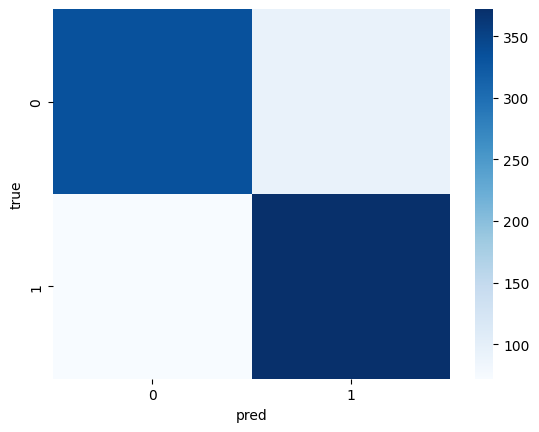

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_dev,y_pred)
print(cm)

sns.heatmap(cm, cmap="Blues")
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

## 67. 精度の計測

学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_train_pred = lr.predict(x_train)

print("===== train =====")
print(accuracy_score(y_train, y_train_pred))
print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))

print("===== dev =====")
print(accuracy_score(y_dev, y_pred))
print(precision_score(y_dev, y_pred))
print(recall_score(y_dev, y_pred))
print(f1_score(y_dev, y_pred))

===== train =====
0.9422857058011255
0.9430676137858458
0.9541377199286646
0.9485703700763439
===== dev =====
0.8096330275229358
0.7982832618025751
0.8378378378378378
0.8175824175824176


## 68. 特徴量の重みの確認

学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [17]:
import numpy as np
coef = lr.coef_[0]
feature_name = vec.get_feature_names_out()

# print(vec.get_feature_names_out())

sort_index = np.argsort(coef)

# print(sort_index)

top20 = [(feature_name[i] ,coef[i]) for i in sort_index[-20:]]
worst20 = [(feature_name[i] ,coef[i]) for i in sort_index[:20]]

print("===== top20 =====")
for name, weight in top20:
    print(f"{name:15s} {weight: .4f}")

print("\n")
print("===== worst20 =====")
for name, weight in worst20:
    print(f"{name:15s} {weight: .4f}")

===== top20 =====
intriguing       2.5680
impressive       2.5946
half-bad         2.6112
fascinating      2.6179
charming         2.6254
solid            2.6462
likable          2.6873
vividly          2.7134
charmer          2.7498
treat            2.7996
enjoyable        2.8143
appealing        2.8535
terrific         2.8651
prose            2.9174
wonderful        2.9729
beautiful        2.9978
hilarious        3.1759
powerful         3.2218
remarkable       3.4165
refreshing       3.4270


===== worst20 =====
lacking         -4.3291
lacks           -4.0801
worst           -3.9918
devoid          -3.6500
mess            -3.6087
failure         -3.5707
stupid          -3.3404
bore            -3.2518
flat            -3.2226
depressing      -3.1884
loses           -3.1680
waste           -3.1570
lack            -3.0595
squanders       -3.0299
none            -3.0197
hardly          -3.0173
poor            -2.9801
pointless       -2.9549
unfortunately   -2.9379
lousy           -2.9299


## 69. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

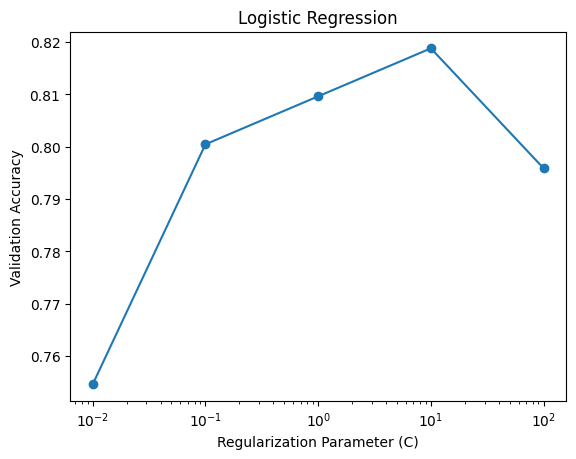

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

hyper = [0.01, 0.1, 1, 10, 100]
accuracies = []

for C in hyper:
    lr = LogisticRegression(C=C, max_iter=1000)
    lr.fit(x_train, y_train)
    
    y_pred = lr.predict(x_dev)
    acc = accuracy_score(y_dev, y_pred)
    accuracies.append(acc)

plt.plot(hyper, accuracies, marker='o')
plt.xscale('log')
plt.xlabel("Regularization Parameter (C)")
plt.ylabel("Validation Accuracy")
plt.title("Logistic Regression")
plt.show()